In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import monai

In [2]:
pd.options.display.max_columns = 100

In [3]:
datapath = Path("/../rsna_data/")
train_df = pd.read_csv(datapath/'train.csv')

In [4]:
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [5]:
do_sample=True
do_cv = False
FOLD = 0

if do_sample:
    sample_pids_dir = (datapath/'sample_pids')
    valid_pids = pd.read_pickle(sample_pids_dir/'valid_pids.pkl')
    train_pids = pd.read_pickle(sample_pids_dir/'train_pids.pkl')
    

if do_cv: 
    cv_pids_dir = (datapath/'cv_pids')
    if not cv_pids_dir.exists(): cv_pids_dir.mkdir()
    cv_df = train_df[['StudyInstanceUID', 'negative_exam_for_pe']].drop_duplicates().reset_index(drop=True)
    all_pids = cv_df['StudyInstanceUID'].values

    valid_pids = pd.read_pickle(datapath/f'cv_pids/pids_fold{FOLD}.pkl')
    train_pids = list(set(all_pids).difference(valid_pids))

In [6]:
len(train_pids), len(valid_pids), len(train_pids+valid_pids)

(80, 20, 100)

In [7]:
metadata_path = datapath/'metadata'
train_metadata_paths = [o for o in metadata_path.ls() if o.stem in train_pids]
valid_metadata_paths = [o for o in metadata_path.ls() if o.stem in valid_pids]

In [8]:
len(train_metadata_paths), len(valid_metadata_paths)

(80, 20)

### All samples

In [9]:
labels_dict = dict(zip(train_df['SOPInstanceUID'], train_df['pe_present_on_image']))

In [10]:
len(labels_dict), len(train_df)

(1790594, 1790594)

In [11]:
imgdatapath = (datapath/'raw_256')

In [12]:
files = get_image_files(imgdatapath)

In [13]:
files[0].parent

Path('/../rsna_data/raw_256/4672b70bfef7')

In [14]:
train_files = [o for o in files if o.parent.name in train_pids]
valid_files = [o for o in files if o.parent.name in valid_pids]

In [15]:
len(train_files), len(valid_files)

(19235, 4635)

In [16]:
files = train_files + valid_files

In [17]:
files_dict = defaultdict(list)
for o in files: files_dict[o.parent.name].append(o)

In [18]:
len(files_dict)

100

### Data

In [19]:
exam_targets = L([
            'negative_exam_for_pe',
            'indeterminate',
            'rv_lv_ratio_gte_1',
            'rv_lv_ratio_lt_1',
            'leftsided_pe',
            'rightsided_pe',
            'central_pe',
            'chronic_pe',
            'acute_and_chronic_pe',           
             ]); exam_targets

(#9) ['negative_exam_for_pe','indeterminate','rv_lv_ratio_gte_1','rv_lv_ratio_lt_1','leftsided_pe','rightsided_pe','central_pe','chronic_pe','acute_and_chronic_pe']

In [20]:
pid2labels = dict(zip(train_df['StudyInstanceUID'], train_df[exam_targets].values))

In [21]:
len(pid2labels)

7279

In [22]:
pid2labels['6897fa9de148']

array([0, 0, 0, 1, 1, 1, 0, 0, 0])

In [23]:
from monai import transforms as monai_tfms

image_size = 160

train_transforms = monai_tfms.Compose([
                            monai_tfms.Resize((image_size, image_size, image_size)), 
                            monai_tfms.RandAffine( 
                                      prob=0.5,
                                      translate_range=(5, 5, 5),
                                      rotate_range=(np.pi * 4, np.pi * 4, np.pi * 4),
                                      scale_range=(0.15, 0.15, 0.15),
                                      padding_mode='border'),
                            monai_tfms.ToTensor()])
val_transforms = monai.transforms.Compose([
                                           monai_tfms.Resize((image_size, image_size, image_size)), 
                                           monai_tfms.ToTensor()])

def get_labels(pid): return pid2labels[pid]
def get_voxel(pid):
    sorted_imgs = sorted(files_dict[pid], key=lambda o: int(o.stem.split("_")[0]))
    sorted_imgs = [image2tensor(PILImage.create(o)).unsqueeze(-1) for o in sorted_imgs]
    stacked_imgs = torch.cat(sorted_imgs, dim=-1)
    return stacked_imgs.float().div_(255)

In [24]:
trn_tfms = [[get_voxel, train_transforms],[get_labels]]
val_tfms = [[get_voxel, val_transforms], [get_labels]]

train_ds = Datasets(train_pids, tfms=trn_tfms)
val_ds = Datasets(valid_pids, tfms=val_tfms)

train_dl = TfmdDL(train_ds, bs=2, shuffle=True)
val_dl = TfmdDL(val_ds, bs=2, shuffle=False)

In [25]:
dls = DataLoaders(train_dl, val_dl, device=default_device())

In [26]:
xb,yb = dls.one_batch()

In [27]:
xb.shape, yb.shape

(torch.Size([2, 3, 160, 160, 160]), torch.Size([2, 9]))

### Learner

In [28]:
from monai.networks import nets as monai_models
model = monai_models.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=9)

In [29]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat())

In [30]:
learn.to_native_fp16();

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.00363078061491251)

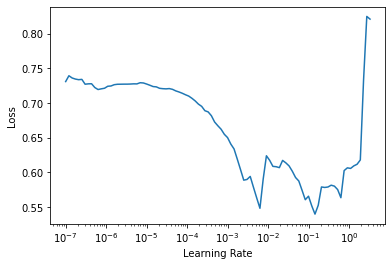

In [59]:
# learn.lr_find()

In [ ]:
learn.fit_flat_cos(20, 3e-3)